In [24]:
import os
import pandas as pd
import logging

# Configure logging to display messages
logging.basicConfig(level=logging.INFO)

# Define the column order
column_order = ["key_resp_control.rt", "key_resp_20.rt", "key_resp_30.rt", "key_resp_bundling.rt",
                "Image","key_resp_control.keys", "Image_20", "key_resp_20.keys", "Image_30","key_resp_30.keys","Image_Bundling", "key_resp_bundling.keys"]

# Function to load and clean data
def load_data(directory_path):
    """
    Load and clean data from CSV files in the specified directory.

    Args:
        directory_path (str): Path to the directory containing CSV files.

    Returns:
        dict: A dictionary of cleaned dataframes with filenames as keys.
    """
    dataframes = {}  # Dictionary to store individual dataframes
    for filename in os.listdir(directory_path):
        if filename.endswith(".csv"):
            file_path = os.path.join(directory_path, filename)
            logging.info(f"Inspecting {filename}...")
            try:
                # Read and clean the CSV file
                df = pd.read_csv(file_path, usecols=column_order)
                df_cleaned = df.apply(lambda x: x.dropna().reset_index(drop=True))
                df_cleaned["key_resp_control.keys"] = df_cleaned["key_resp_control.keys"].astype(int)
                df_cleaned["key_resp_20.keys"] = df_cleaned["key_resp_20.keys"].astype(int)
                df_cleaned["key_resp_30.keys"] = df_cleaned["key_resp_30.keys"].astype(int)
                df_cleaned["key_resp_bundling.keys"] = df_cleaned["key_resp_bundling.keys"].astype(int)
                df_cleaned = df_cleaned[column_order]  # Reorder columns
                dataframes[filename] = df_cleaned  # Store the dataframe with the filename as the key
            except Exception as e:
                logging.error(f"Error processing {filename}: {e}")
    
    if dataframes:
        return dataframes  # Return the dictionary of dataframes
    else:
        logging.warning("No valid CSV files found or processed.")
        return None

# Example usage
directory_path = "/Users/manastanavde/Downloads/RES501_data_final"
dataframes = load_data(directory_path)

# Print the cleaned dataframes for inspection
if dataframes:
    for filename, df in dataframes.items():
        print(f"Cleaned DataFrame for {filename}:")
        print(df)  # Display the first few rows of the dataframe
        print("\n")
else:
    print("No data was loaded.")

INFO:root:Inspecting 72993_RES501_2025-03-28_12h29.57.248.csv...
INFO:root:Inspecting 58896_RES501_2025-04-02_18h39.51.468.csv...
INFO:root:Inspecting 78857_RES501_2025-03-28_21h11.45.414.csv...
INFO:root:Inspecting 92622_RES501_2025-04-02_18h20.49.086.csv...
INFO:root:Inspecting 85707_RES501_2025-04-02_18h23.15.142.csv...
INFO:root:Inspecting 41198_RES501_2025-04-02_12h04.49.915.csv...
INFO:root:Inspecting 63183_RES501_2025-03-31_22h33.40.399.csv...
INFO:root:Inspecting 34752_RES501_2025-03-26_14h03.26.401.csv...
INFO:root:Inspecting 88863_RES501_2025-04-02_18h32.00.899.csv...
INFO:root:Inspecting 57302_RES501_2025-04-02_18h25.26.993.csv...
INFO:root:Inspecting 88693_RES501_2025-03-26_14h56.29.653.csv...
INFO:root:Inspecting 34688_RES501_2025-04-02_18h29.51.570.csv...
INFO:root:Inspecting 54918_RES501_2025-03-26_14h29.11.396.csv...
ERROR:root:Error processing 54918_RES501_2025-03-26_14h29.11.396.csv: Usecols do not match columns, columns expected but not found: ['Image_Bundling']
INFO

Cleaned DataFrame for 72993_RES501_2025-03-28_12h29.57.248.csv:
   key_resp_control.rt  key_resp_20.rt  key_resp_30.rt  key_resp_bundling.rt  \
0            24.040117       20.131692       10.881833              1.700678   
1            27.055547       36.335160       14.558594              8.230843   
2             9.380530       28.063124       24.310205              4.102003   
3            68.050033        7.230996       15.896530              0.960096   
4            31.402866       17.714978        6.089774              1.937179   
5            20.621968        3.163064        2.047282             15.315540   

                    Image  key_resp_control.keys           Image_20  \
0  CrunchyrollControl.jpg                      2      Netflix20.jpg   
1         Zee5Control.jpg                      1      SonyLiv20.jpg   
2      NetflixControl.jpg                      4      Hotstar20.jpg   
3      HotstarControl.jpg                      3  Crunchyroll20.jpg   
4      SonyLivContro

In [25]:
import pandas as pd
from collections import defaultdict

def detect_switches(df, cumulative_switch_counts, cumulative_special_switches, df_name):
    print(f"Processing dataframe: {df_name}")
    
    # Rename 'Image' column to 'Image_Control' if it exists
    if "Image" in df.columns and "Image_Control" not in df.columns:
        df = df.rename(columns={"Image": "Image_Control"})
    
    # Store base key mappings
    base_key_map = {}
    for _, row in df.iterrows():
        image_type = row["Image_Control"].replace("Control", "").replace(".jpg", "").strip()
        base_key_map[image_type] = int(row["key_resp_control.keys"])
    
    print("Base Key Map:", base_key_map)  # Debugging
    
    switch_counts = defaultdict(int)
    special_switches = defaultdict(lambda: {"20": 0, "30": 0, "Bundling": 0})

    for col, response_col, condition in zip(
        ["Image_20", "Image_30", "Image_Bundling"],
        ["key_resp_20.keys", "key_resp_30.keys", "key_resp_bundling.keys"],
        ["20", "30", "Bundling"]
    ):
        if col in df.columns and response_col in df.columns:
            for _, row in df.iterrows():
                image_type = row[col].replace(".jpg", "").strip()
                image_type = image_type.replace("20", "").replace("30", "").replace("Bundling", "").strip()
                base_key = base_key_map.get(image_type)

                if base_key is None:
                    print(f"Warning: {image_type} not found in base_key_map")  # Debugging
                else:
                    new_key = int(row[response_col])

                    if base_key != new_key:
                        # Ensure Total Switches is only incremented once per image_type per dataset
                        if switch_counts[image_type] == 0:
                            switch_counts[image_type] += 1

                        special_conditions = {
                            "Netflix": base_key in [1, 2, 3] and new_key == 4,
                            "AppleOne": base_key == 1 and new_key == 2,
                            "Crunchyroll": base_key in [1, 2] and new_key == 3,
                            "Zee5": base_key in [2, 3] and new_key == 1,
                            "SonyLiv": base_key in [1, 3] and new_key == 2,
                            "Hotstar": base_key in [1, 2] and new_key == 3
                        }

                        if special_conditions.get(image_type, False):
                            special_switches[image_type][condition] += 1  # Track per condition
    
    # Update cumulative counts
    for key, value in switch_counts.items():
        cumulative_switch_counts[key] += value

    for key, value in special_switches.items():
        for cond, count in value.items():
            cumulative_special_switches[key][cond] += count
    
    # Convert to DataFrame
    special_switches_df = pd.DataFrame.from_dict(special_switches, orient="index").fillna(0).astype(int)
    
    # Add "Special" column (sum of all special switch conditions: 20, 30, Bundling)
    special_switches_df["Special"] = special_switches_df.sum(axis=1)

    # Create the final DataFrame with Total Switches
    result_df = pd.DataFrame({"Total Switches": switch_counts}).join(special_switches_df).fillna(0).astype(int)
    
    return result_df

# Cumulative storage for all datasets
cumulative_switch_counts = defaultdict(int)
cumulative_special_switches = defaultdict(lambda: defaultdict(int))

# Example usage with cleaned dataframes
summary_list = []

for df_name, dataframe in dataframes.items():
    summary_list.append(detect_switches(dataframe, cumulative_switch_counts, cumulative_special_switches, df_name))

# Display individual summaries
for summary in summary_list:
    print(summary)
    print("\n")

# Create and display cumulative summary
total_summary_df = pd.DataFrame.from_dict(cumulative_special_switches, orient="index").fillna(0).astype(int)
total_summary_df["Total Switches"] = pd.Series(cumulative_switch_counts)

# NEW: Add the "Special" column by summing across 20, 30, and Bundling
total_summary_df["Special"] = total_summary_df[["20", "30", "Bundling"]].sum(axis=1)

print("Cumulative Summary:")
print(total_summary_df)


Processing dataframe: 72993_RES501_2025-03-28_12h29.57.248.csv
Base Key Map: {'Crunchyroll': 2, 'Zee5': 1, 'Netflix': 4, 'Hotstar': 3, 'SonyLiv': 3, 'AppleOne': 2}
Processing dataframe: 58896_RES501_2025-04-02_18h39.51.468.csv
Base Key Map: {'SonyLiv': 2, 'AppleOne': 1, 'Hotstar': 2, 'Zee5': 3, 'Crunchyroll': 2, 'Netflix': 3}
Processing dataframe: 78857_RES501_2025-03-28_21h11.45.414.csv
Base Key Map: {'AppleOne': 2, 'Zee5': 1, 'SonyLiv': 3, 'Crunchyroll': 1, 'Netflix': 3, 'Hotstar': 1}
Processing dataframe: 92622_RES501_2025-04-02_18h20.49.086.csv
Base Key Map: {'SonyLiv': 1, 'Crunchyroll': 2, 'AppleOne': 1, 'Netflix': 3, 'Hotstar': 2, 'Zee5': 1}
Processing dataframe: 85707_RES501_2025-04-02_18h23.15.142.csv
Base Key Map: {'AppleOne': 1, 'Hotstar': 1, 'Netflix': 2, 'Crunchyroll': 1, 'SonyLiv': 3, 'Zee5': 2}
Processing dataframe: 41198_RES501_2025-04-02_12h04.49.915.csv
Base Key Map: {'Hotstar': 1, 'SonyLiv': 1, 'Zee5': 1, 'Netflix': 2, 'AppleOne': 1, 'Crunchyroll': 1}
Processing dataf

In [26]:
from collections import defaultdict

def detect_switches_with_counts(
    df, 
    cumulative_switch_counts, 
    cumulative_special_switches, 
    cumulative_special_rts, 
    special_switch_counter, 
    non_special_switch_counter, 
    special_rt_total, 
    non_special_rt_total, 
    df_name
):
    print(f"Processing dataframe: {df_name}")
    
    # Rename 'Image' column to 'Image_Control' if it exists
    if "Image" in df.columns and "Image_Control" not in df.columns:
        df = df.rename(columns={"Image": "Image_Control"})
    
    # Store base key mappings
    base_key_map = {}
    for _, row in df.iterrows():
        image_type = row["Image_Control"].replace("Control", "").replace(".jpg", "").strip()
        base_key_map[image_type] = int(row["key_resp_control.keys"])
    
    print("Base Key Map:", base_key_map)  # Debugging
    
    switch_counts = defaultdict(int)
    special_switches = defaultdict(lambda: {"20": 0, "30": 0, "Bundling": 0})
    special_rts = defaultdict(lambda: {"20": [], "30": [], "Bundling": []})  # Store reaction times for special switches

    for col, response_col, rt_col, condition in zip(
        ["Image_20", "Image_30", "Image_Bundling"],
        ["key_resp_20.keys", "key_resp_30.keys", "key_resp_bundling.keys"],
        ["key_resp_20.rt", "key_resp_30.rt", "key_resp_bundling.rt"],
        ["20", "30", "Bundling"]
    ):
        if col in df.columns and response_col in df.columns and rt_col in df.columns:
            for _, row in df.iterrows():
                image_type = row[col].replace(".jpg", "").strip()
                image_type = image_type.replace("20", "").replace("30", "").replace("Bundling", "").strip()
                base_key = base_key_map.get(image_type)

                if base_key is None:
                    print(f"Warning: {image_type} not found in base_key_map")  # Debugging
                else:
                    new_key = int(row[response_col])

                    if base_key != new_key:
                        # Ensure Total Switches is only incremented once per image_type per dataset
                        if switch_counts[image_type] == 0:
                            switch_counts[image_type] += 1

                        special_conditions = {
                            "Netflix": base_key in [1, 2, 3] and new_key == 4,
                            "AppleOne": base_key == 1 and new_key == 2,
                            "Crunchyroll": base_key in [1, 2] and new_key == 3,
                            "Zee5": base_key in [2, 3] and new_key == 1,
                            "SonyLiv": base_key in [1, 3] and new_key == 2,
                            "Hotstar": base_key in [1, 2] and new_key == 3
                        }

                        if special_conditions.get(image_type, False):
                            # Increment special switch counter and add reaction time
                            special_switch_counter += 1
                            special_rt_total += row[rt_col]
                            special_switches[image_type][condition] += 1
                            special_rts[image_type][condition].append(row[rt_col])
                        else:
                            # Increment non-special switch counter and add reaction time
                            non_special_switch_counter += 1
                            non_special_rt_total += row[rt_col]
    
    # Update cumulative counts
    for key, value in switch_counts.items():
        cumulative_switch_counts[key] += value

    for key, value in special_switches.items():
        for cond, count in value.items():
            cumulative_special_switches[key][cond] += count

    for key, value in special_rts.items():
        for cond, rts in value.items():
            cumulative_special_rts[key][cond].extend(rts)  # Append reaction times

    # Convert to DataFrame
    special_switches_df = pd.DataFrame.from_dict(special_switches, orient="index").fillna(0).astype(int)
    
    # Add "Special" column (sum of all special switch conditions: 20, 30, Bundling)
    special_switches_df["Special"] = special_switches_df.sum(axis=1)

    # Create the final DataFrame with Total Switches
    result_df = pd.DataFrame({"Total Switches": switch_counts}).join(special_switches_df).fillna(0).astype(int)
    
    return result_df

# Cumulative storage for all datasets
cumulative_switch_counts = defaultdict(int)
cumulative_special_switches = defaultdict(lambda: defaultdict(int))
cumulative_special_rts = defaultdict(lambda: defaultdict(list))  # Store reaction times for special switches

# Example usage with cleaned dataframes
summary_list = []

for df_name, dataframe in dataframes.items():
    summary_list.append(detect_switches_with_counts(
        dataframe, 
        cumulative_switch_counts, 
        cumulative_special_switches, 
        cumulative_special_rts, 
        special_switch_counter=0, 
        non_special_switch_counter=0, 
        special_rt_total=0, 
        non_special_rt_total=0, 
        df_name=df_name
    ))
# Display individual summaries
for summary in summary_list:
    print(summary)
    print("\n")

# Create and display cumulative summary
total_summary_df = pd.DataFrame.from_dict(cumulative_special_switches, orient="index").fillna(0).astype(int)
total_summary_df["Total Switches"] = pd.Series(cumulative_switch_counts)

# NEW: Add the "Special" column by summing across 20, 30, and Bundling
total_summary_df["Special"] = total_summary_df[["20", "30", "Bundling"]].sum(axis=1)

print("Cumulative Summary:")
print(total_summary_df)

# Flatten special reaction times into a DataFrame
special_rts_df = pd.DataFrame.from_dict(cumulative_special_rts, orient="index")

# Debugging: Check cumulative special reaction times
print("\nCumulative Special Reaction Times:")
for platform, conditions in cumulative_special_rts.items():
    print(f"{platform}: {conditions}")

# Flatten special reaction times into a DataFrame
special_rts_df = pd.DataFrame.from_dict(cumulative_special_rts, orient="index")

# Convert lists of reaction times into their sum
special_rts_df = special_rts_df.applymap(lambda x: sum(x) if isinstance(x, list) else 0)

# Replace <NA> values with 0
special_rts_df = special_rts_df.fillna(0)

# Debugging: Check special RTs DataFrame
print("\nSpecial Reaction Times DataFrame:")
print(special_rts_df)

# Debugging: Check cumulative special reaction times
print("\nCumulative Special Reaction Times:")
for platform, conditions in cumulative_special_rts.items():
    print(f"{platform}: {conditions}")

# Flatten special reaction times into a DataFrame
special_rts_count_df = pd.DataFrame.from_dict(cumulative_special_rts, orient="index")

# Convert lists of reaction times into their counts
special_rts_count_df = special_rts_count_df.applymap(lambda x: len(x) if isinstance(x, list) else 0)

# Replace <NA> values with 0
special_rts_count_df = special_rts_count_df.fillna(0)

# Debugging: Check special RT counts DataFrame
print("\nSpecial Reaction Times Count DataFrame:")
print(special_rts_count_df)

Processing dataframe: 72993_RES501_2025-03-28_12h29.57.248.csv
Base Key Map: {'Crunchyroll': 2, 'Zee5': 1, 'Netflix': 4, 'Hotstar': 3, 'SonyLiv': 3, 'AppleOne': 2}
Processing dataframe: 58896_RES501_2025-04-02_18h39.51.468.csv
Base Key Map: {'SonyLiv': 2, 'AppleOne': 1, 'Hotstar': 2, 'Zee5': 3, 'Crunchyroll': 2, 'Netflix': 3}
Processing dataframe: 78857_RES501_2025-03-28_21h11.45.414.csv
Base Key Map: {'AppleOne': 2, 'Zee5': 1, 'SonyLiv': 3, 'Crunchyroll': 1, 'Netflix': 3, 'Hotstar': 1}
Processing dataframe: 92622_RES501_2025-04-02_18h20.49.086.csv
Base Key Map: {'SonyLiv': 1, 'Crunchyroll': 2, 'AppleOne': 1, 'Netflix': 3, 'Hotstar': 2, 'Zee5': 1}
Processing dataframe: 85707_RES501_2025-04-02_18h23.15.142.csv
Base Key Map: {'AppleOne': 1, 'Hotstar': 1, 'Netflix': 2, 'Crunchyroll': 1, 'SonyLiv': 3, 'Zee5': 2}
Processing dataframe: 41198_RES501_2025-04-02_12h04.49.915.csv
Base Key Map: {'Hotstar': 1, 'SonyLiv': 1, 'Zee5': 1, 'Netflix': 2, 'AppleOne': 1, 'Crunchyroll': 1}
Processing dataf

/var/folders/0d/_lnnsfh93pz0gjfnhb8wjd1m0000gp/T/ipykernel_10813/3296909937.py:144: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  special_rts_df = special_rts_df.applymap(lambda x: sum(x) if isinstance(x, list) else 0)
/var/folders/0d/_lnnsfh93pz0gjfnhb8wjd1m0000gp/T/ipykernel_10813/3296909937.py:162: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  special_rts_count_df = special_rts_count_df.applymap(lambda x: len(x) if isinstance(x, list) else 0)


In [27]:
import pandas as pd

def extract_rt_to_cumulative_df(dataframes):
    """
    Extract reaction time (.rt) columns from all dataframes and combine them into a cumulative dataframe.

    Args:
        dataframes (dict): A dictionary of dataframes with filenames as keys.

    Returns:
        pd.DataFrame: A cumulative dataframe containing .rt columns from all dataframes.
    """
    cumulative_data = []  # List to store extracted dataframes

    for filename, df in dataframes.items():
        # Create a temporary dataframe to store reaction times and corresponding platforms
        extracted_df = pd.DataFrame()

        # Extract reaction times and corresponding platform names
        extracted_df["key_resp_control.rt"] = df["key_resp_control.rt"]
        extracted_df["Platform_Control"] = df["Image"].str.replace("Control.jpg", "").str.replace(".jpg", "").str.strip()

        extracted_df["key_resp_20.rt"] = df["key_resp_20.rt"]
        extracted_df["Platform_20"] = df["Image_20"].str.replace("_20.jpg", "").str.replace("20.jpg", "").str.replace(".jpg", "").str.strip()

        extracted_df["key_resp_30.rt"] = df["key_resp_30.rt"]
        extracted_df["Platform_30"] = df["Image_30"].str.replace("_30.jpg", "").str.replace("30.jpg", "").str.replace(".jpg", "").str.strip()

        extracted_df["key_resp_bundling.rt"] = df["key_resp_bundling.rt"]
        extracted_df["Platform_Bundling"] = df["Image_Bundling"].str.replace("_Bundling.jpg", "").str.replace("Bundling.jpg", "").str.replace(".jpg", "").str.strip()

        # Add a column for the source filename
        extracted_df["Source_File"] = filename

        # Append to the cumulative data list
        cumulative_data.append(extracted_df)

    # Concatenate all extracted dataframes into one cumulative dataframe
    cumulative_df = pd.concat(cumulative_data, ignore_index=True)
    
    return cumulative_df

# Example usage
cumulative_rt_df = extract_rt_to_cumulative_df(dataframes)

# Display the cumulative dataframe
print("Cumulative Reaction Time DataFrame with Cleaned Platform Data:")
print(cumulative_rt_df)

# # Optionally, save the cumulative dataframe to a CSV file
# cumulative_rt_df.to_csv("cumulative_rt.csv", index=False)

# Group and sum reaction times by platform for each condition
total_rts = {
    "20": cumulative_rt_df.groupby("Platform_20")["key_resp_20.rt"].sum(),
    "30": cumulative_rt_df.groupby("Platform_30")["key_resp_30.rt"].sum(),
    "Bundling": cumulative_rt_df.groupby("Platform_Bundling")["key_resp_bundling.rt"].sum(),
}

# Convert the dictionary to a DataFrame
total_rts_df = pd.DataFrame(total_rts)

# Replace NaN values with 0
total_rts_df = total_rts_df.fillna(0)

# Debugging: Check total RTs DataFrame
print("\nTotal Reaction Times DataFrame:")
print(total_rts_df)

# Group and count reaction times by platform for each condition
total_rts_counts = {
    "20": cumulative_rt_df.groupby("Platform_20")["key_resp_20.rt"].count(),
    "30": cumulative_rt_df.groupby("Platform_30")["key_resp_30.rt"].count(),
    "Bundling": cumulative_rt_df.groupby("Platform_Bundling")["key_resp_bundling.rt"].count(),
}

# Convert the dictionary to a DataFrame
total_rts_count_df = pd.DataFrame(total_rts_counts)

# Replace NaN values with 0
total_rts_count_df = total_rts_count_df.fillna(0).astype(int)

# Debugging: Check total RT counts DataFrame
print("\nTotal Reaction Times Count DataFrame:")
print(total_rts_count_df)

# Subtract special reaction times from total reaction times
non_special_rts_df = total_rts_df.subtract(special_rts_df, fill_value=0)

# Replace negative values with 0 (if any)
non_special_rts_df = non_special_rts_df.clip(lower=0)

# Debugging: Check non-special RTs DataFrame
print("\nNon-Special Reaction Times DataFrame:")
print(non_special_rts_df)

# Subtract special reaction times counts from total reaction times counts
non_special_rts_count_df = total_rts_count_df.subtract(special_rts_count_df)

# Replace negative values with 0 (if any)
non_special_rts_count_df = non_special_rts_count_df.clip(lower=0)

# Debugging: Check non-special RT counts DataFrame
print("\nNon-Special Reaction Times Count DataFrame:")
print(non_special_rts_count_df)

Cumulative Reaction Time DataFrame with Cleaned Platform Data:
     key_resp_control.rt Platform_Control  key_resp_20.rt  Platform_20  \
0              24.040117      Crunchyroll       20.131692      Netflix   
1              27.055547             Zee5       36.335160      SonyLiv   
2               9.380530          Netflix       28.063124      Hotstar   
3              68.050033          Hotstar        7.230996  Crunchyroll   
4              31.402866          SonyLiv       17.714978     AppleOne   
..                   ...              ...             ...          ...   
181            42.952440          Hotstar       23.065919     AppleOne   
182           102.561426             Zee5       18.882260         Zee5   
183            52.175473      Crunchyroll       78.165007      SonyLiv   
184            73.673571          SonyLiv       69.069419  Crunchyroll   
185            26.280075         AppleOne       12.882104      Hotstar   

     key_resp_30.rt  Platform_30  key_resp_bundl

Descriptive Statistics for Reaction Times:
       key_resp_control.rt  key_resp_20.rt  key_resp_30.rt  \
count           186.000000      186.000000      186.000000   
mean             20.735731       10.592614        7.794862   
std              27.002511       11.973470        8.582901   
min               1.298425        0.737311        0.953019   
25%               3.892222        3.122014        2.662917   
50%              13.857825        5.834946        4.349022   
75%              26.990039       13.109965       10.204752   
max             280.021340       78.165007       53.314705   

       key_resp_bundling.rt  
count            186.000000  
mean               8.937236  
std               10.163155  
min                0.178167  
25%                2.642870  
50%                4.238538  
75%               11.944470  
max               68.963534  


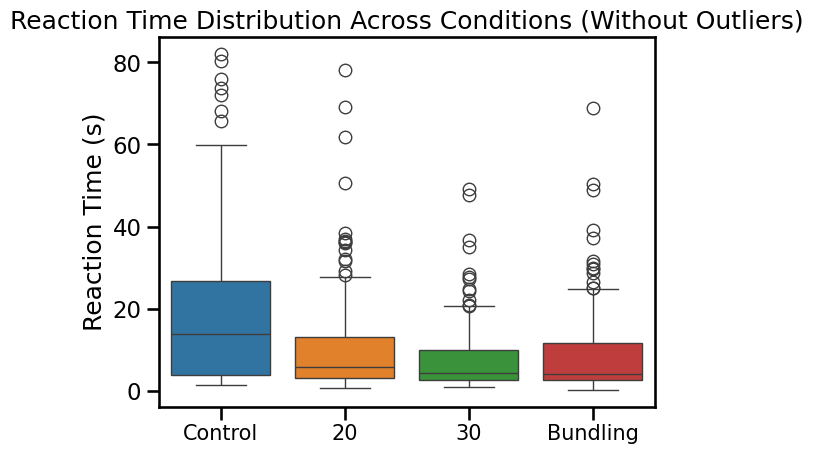


Proportion of Switches by Condition:
20          0.047043
30          0.069892
Bundling    0.068548
dtype: float64


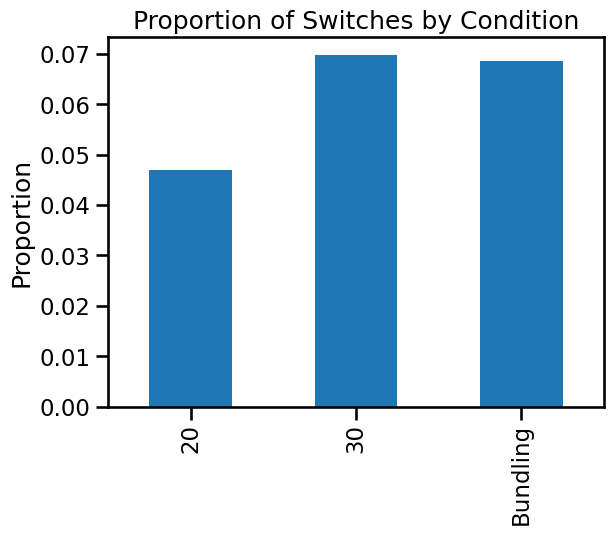


One-Way ANOVA for Reaction Times:
ANOVA Results: F-statistic = 24.897119852529435, p-value = 2.355629169100486e-15

Chi-Square Test for Switching Behavior:
Observed values for Chi-Square Test: [35 52 51]
Expected values for Chi-Square Test: [46.0, 46.0, 46.0]
Chi-Square Test: Chi2-statistic = 3.9565217391304346, p-value = 0.13830956664506264

Correlation Between Reaction Times and Switches:
Aligned Reaction Times:
Crunchyroll    11.561054
Zee5           11.296300
AppleOne        9.914273
Hotstar        15.480203
Netflix        10.876111
SonyLiv        12.962723
Name: Reaction_Time, dtype: float64
Aligned Switches:
Crunchyroll    15
Zee5           26
AppleOne       21
Hotstar        26
Netflix        23
SonyLiv        27
dtype: int64
Correlation: 0.4472417432093425

Proportion of Special Switches by Platform:
Crunchyroll    0.020161
Zee5           0.034946
AppleOne       0.028226
Hotstar        0.034946
Netflix        0.030914
SonyLiv        0.036290
Name: Special, dtype: float64


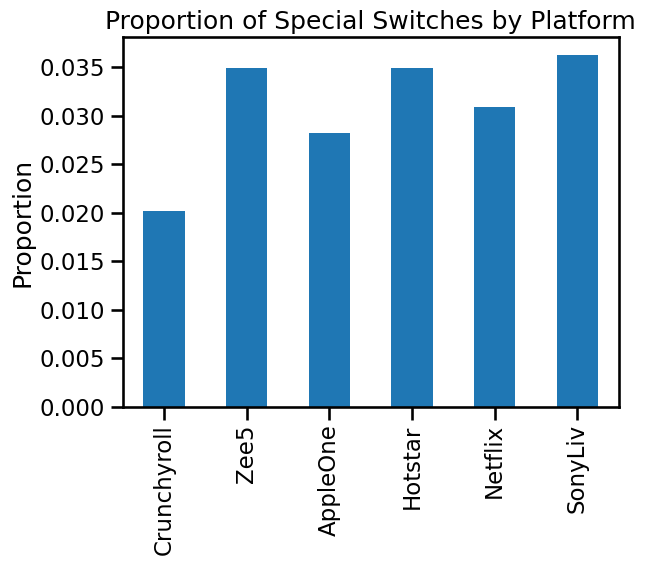


T-Test for Special vs. Non-Special Reaction Times:

Flattened Mean Special Reaction Times: [np.float64(5.447710116764938), np.float64(12.87564703557902), np.float64(5.371935193728518), np.float64(5.571853759351143), np.float64(4.158854191742648), np.float64(12.077105280805686), np.float64(6.489024227435168), np.float64(7.779238876123729), np.float64(5.946177828566371), np.float64(5.985851459858774), np.float64(13.939609770484926), np.float64(13.413829662092638), np.float64(7.882860249996881), np.float64(8.75469610832574), np.float64(11.287402265786277), np.float64(18.766143605264915), np.float64(13.87191179253933), np.float64(12.759032142485376)]

Flattened Mean Non-Special Reaction Times: [np.float64(10.392425132584878), np.float64(6.314746222389154), np.float64(9.744915758705616), np.float64(11.69735957407064), np.float64(7.102127093083676), np.float64(7.124420156147736), np.float64(10.913581110840898), np.float64(6.793145114499023), np.float64(7.310986759096958), np.float64(12.3944

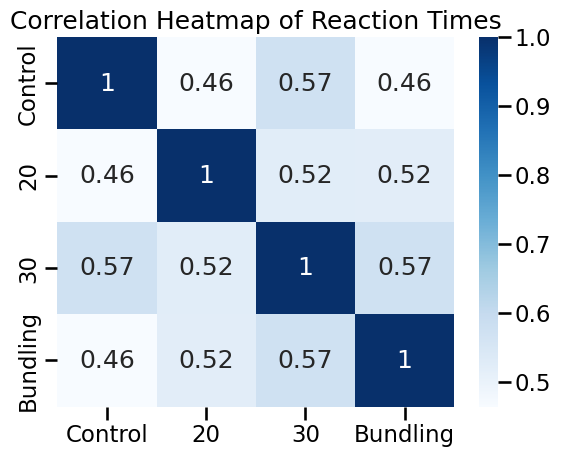


Stacked Bar Plot for Switch Distribution by Platform:


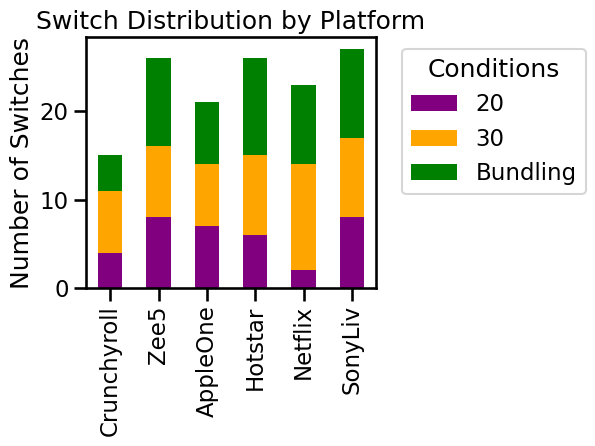

In [31]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway, chi2_contingency, ttest_ind

# Assuming `cumulative_rt_df` and `total_summary_df` are already defined
# Replace these with your actual dataframes if needed

# Total number of trials
total_trials = len(cumulative_rt_df["Source_File"].unique()) * 24

# 1. Descriptive Statistics for Reaction Times
print("Descriptive Statistics for Reaction Times:")
rt_summary = cumulative_rt_df.describe()
print(rt_summary)

# Define the threshold for outliers
threshold = 100

# Filter out reaction times greater than the threshold
filtered_rt_df = cumulative_rt_df[
    (cumulative_rt_df["key_resp_control.rt"] <= threshold) &
    (cumulative_rt_df["key_resp_20.rt"] <= threshold) &
    (cumulative_rt_df["key_resp_30.rt"] <= threshold) &
    (cumulative_rt_df["key_resp_bundling.rt"] <= threshold)
]

# Boxplot for Reaction Times (without outliers)
sns.boxplot(data=filtered_rt_df[["key_resp_control.rt", "key_resp_20.rt", "key_resp_30.rt", "key_resp_bundling.rt"]])
plt.title("Reaction Time Distribution Across Conditions (Without Outliers)")
plt.ylabel("Reaction Time (s)")
# Change x-axis labels
plt.xticks(ticks=[0, 1, 2, 3], labels=["Control", "20", "30", "Bundling"], fontsize=15)  # Adjust fontsize as needed
plt.show()

# 2. Proportion of Switches by Condition
print("\nProportion of Switches by Condition:")
switch_proportions = total_summary_df[["20", "30", "Bundling"]].sum() / total_trials
print(switch_proportions)

# Bar Plot for Switch Proportions
switch_proportions.plot(kind="bar", title="Proportion of Switches by Condition")
plt.ylabel("Proportion")
plt.show()

# 3. One-Way ANOVA for Reaction Times
print("\nOne-Way ANOVA for Reaction Times:")
f_stat, p_value = f_oneway(
    cumulative_rt_df["key_resp_control.rt"],
    cumulative_rt_df["key_resp_20.rt"],
    cumulative_rt_df["key_resp_30.rt"],
    cumulative_rt_df["key_resp_bundling.rt"]
)
print(f"ANOVA Results: F-statistic = {f_stat}, p-value = {p_value}")

# 4. Chi-Square Test for Switching Behavior
print("\nChi-Square Test for Switching Behavior:")

# Observed values (sum of switches for each condition)
observed = total_summary_df[["20", "30", "Bundling"]].sum().values

# Expected values (uniform distribution)
expected = [float(observed.sum() / len(observed))] * len(observed)

print("Observed values for Chi-Square Test:", observed)
print("Expected values for Chi-Square Test:", expected)

# Perform the Chi-Square test only if there is variability
if observed.sum() > 0 and len(set(observed)) > 1:  # Ensure variability
    from scipy.stats import chisquare
    chi2_stat, p_value = chisquare(f_obs=observed, f_exp=expected)
    print(f"Chi-Square Test: Chi2-statistic = {chi2_stat}, p-value = {p_value}")
else:
    print("Chi-Square Test cannot be performed due to lack of variability.")

# 5. Correlation Between Reaction Times and Switches
print("\nCorrelation Between Reaction Times and Switches:")

# Flatten the reaction times and platforms into a single dataframe
flattened_df = pd.DataFrame({
    "Reaction_Time": pd.concat([
        cumulative_rt_df["key_resp_control.rt"],
        cumulative_rt_df["key_resp_20.rt"],
        cumulative_rt_df["key_resp_30.rt"],
        cumulative_rt_df["key_resp_bundling.rt"]
    ]),
    "Platform": pd.concat([
        cumulative_rt_df["Platform_Control"],
        cumulative_rt_df["Platform_20"],
        cumulative_rt_df["Platform_30"],
        cumulative_rt_df["Platform_Bundling"]
    ])
})

# Drop rows with NaN values (in case some reaction times or platforms are missing)
flattened_df = flattened_df.dropna()

# Aggregate reaction times by platform (mean across all conditions)
aggregated_rt = flattened_df.groupby("Platform")["Reaction_Time"].mean()

# Ensure the indices of aggregated_rt and total_summary_df are aligned
aggregated_rt.index = aggregated_rt.index.str.strip()  # Remove any leading/trailing spaces
total_summary_df.index = total_summary_df.index.str.strip()  # Remove any leading/trailing spaces

# Align the reaction times and switches
aligned_rt = aggregated_rt.reindex(total_summary_df.index)
aligned_switches = total_summary_df[["20", "30", "Bundling"]].sum(axis=1)

# Check for NaN values or misalignment
print("Aligned Reaction Times:")
print(aligned_rt)
print("Aligned Switches:")
print(aligned_switches)

# Perform the correlation analysis only if both datasets have sufficient data and variability
if len(aligned_rt.dropna()) > 1 and len(aligned_switches.dropna()) > 1 and aligned_rt.std() > 0 and aligned_switches.std() > 0:
    correlation = aligned_rt.corr(aligned_switches)
    print(f"Correlation: {correlation}")
else:
    print("Correlation cannot be calculated due to insufficient data or lack of variability.")

# 6. Proportion of Special Switches by Platform
print("\nProportion of Special Switches by Platform:")
special_switch_proportions = total_summary_df["Special"] / total_trials
print(special_switch_proportions)

# Bar Plot for Special Switch Proportions
special_switch_proportions.plot(kind="bar", title="Proportion of Special Switches by Platform")
plt.ylabel("Proportion")
plt.show()

#7. T-Test for Special vs. Non-Special Reaction Times
print("\nT-Test for Special vs. Non-Special Reaction Times:")
# Calculate mean reaction times for special reaction times
mean_special_rts_df = special_rts_df.div(special_rts_count_df).fillna(0)

# Calculate mean reaction times for non-special reaction times
mean_non_special_rts_df = non_special_rts_df.div(non_special_rts_count_df).fillna(0)

# Flatten mean reaction times into lists
special_rt = mean_special_rts_df.values.flatten()
non_special_rt = mean_non_special_rts_df.values.flatten()

# Remove zeros or invalid values (if any)
special_rt = [rt for rt in special_rt if rt > 0]
non_special_rt = [rt for rt in non_special_rt if rt > 0]

# Debugging: Check the flattened lists
print("\nFlattened Mean Special Reaction Times:", special_rt)
print("\nFlattened Mean Non-Special Reaction Times:", non_special_rt)

# Perform the T-Test only if both datasets have sufficient data
if len(special_rt) > 1 and len(non_special_rt) > 1:
    t_stat, p_value = ttest_ind(special_rt, non_special_rt, equal_var=False)
    print("\nT-Test Results:")
    print(f"T-Statistic: {t_stat}")
    print(f"P-Value: {p_value}")
else:
    print("\nT-Test cannot be performed due to insufficient data.")

import seaborn as sns
import matplotlib.pyplot as plt

# Heatmap of Reaction Time Correlations
sns.set_context("talk")
print("\nHeatmap of Reaction Time Correlations:")

reaction_time_columns = ["key_resp_control.rt", "key_resp_20.rt", "key_resp_30.rt", "key_resp_bundling.rt"]

# Compute the correlation matrix
correlation_matrix = cumulative_rt_df[reaction_time_columns].corr()

# Create the heatmap with custom labels
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="Blues",
    xticklabels=["Control", "20", "30", "Bundling"],  # Custom x-axis labels
    yticklabels=["Control", "20", "30", "Bundling"]   # Custom y-axis labels
)

plt.title("Correlation Heatmap of Reaction Times")
plt.show()

# 9. Stacked Bar Plot for Switch Distribution by Platform
print("\nStacked Bar Plot for Switch Distribution by Platform:")

# Define custom colors for the stacked bars
custom_colors = ['purple', 'orange', 'green']  # Colors for "20", "30", and "Bundling"

# Create the stacked bar plot with custom colors
ax = total_summary_df[["20", "30", "Bundling"]].plot(
    kind="bar",
    stacked=True,
    color=custom_colors,  # Apply custom colors
    title="Switch Distribution by Platform"
)

# Add labels
plt.ylabel("Number of Switches")

# Move the legend outside the graph area
plt.legend(
    loc='upper left',  # Position the legend relative to the plot
    bbox_to_anchor=(1.05, 1),  # Place the legend outside the graph (to the right)
    title="Conditions"  # Add a title to the legend
)

# Adjust layout to prevent clipping
plt.tight_layout()

# Show the plot
plt.show()